# Datos

## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sep = '\n' + '-' * 20 + '\n'

## Leer datos

In [2]:
fpath = '../data'
fname = 'Groceries_dataset.csv' 
df = pd.read_csv(os.path.join(fpath, fname))

#url = 'https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba/download?datasetVersionNumber=2'
#df = pd.read_csv(url)


num_filas = len(df)
print(f'Datos leidos - {num_filas} filas', sep)
print('Tipo de datos:\n\n', df.dtypes, sep)
print('Sample:\n', df.sample(3))

Datos leidos - 38765 filas 
--------------------

Tipo de datos:

 Member_number       int64
Date               object
itemDescription    object
dtype: object 
--------------------

Sample:
        Member_number        Date   itemDescription
21408           2357  03-08-2015  specialty cheese
19409           3445  01-10-2015     cream cheese 
9221            3732  18-01-2014         ice cream


## Acondicionar y limpiar datos

In [3]:
# 1) Quality check de datos
m = df.isnull().any(axis=1)
df = df[~m]

# 2) cambiamos el nombre de las columnas para tener una convencion y no confundirnos despues
df = df.rename(columns={'Member_number': 'member_number', 'Date': 'date',
                        'itemDescription': 'item_description'})

# 3) Le aclaramos al sistema que el campo "date" es de tipo datetime, para poder hacer calculos mas facilmente 
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# 4) Como las compras estan por item, cliente y dia, agregamos un campo "cantidad" (=1) para poder agrupar
df['quantity'] = 1

# 5) Armamos un campo auxiliar usando la combinacion fecha-cliente para poder agrupar transacciones
# estamos asumiendo que el cliente va como maximo una vez por dia al supermercado...
# En un caso real, la base suele tener lo que se llama "transaction id", con el carrito de compra, aca lo inventamos
df['transaction_id'] = df[['member_number', 'date']].apply(tuple, axis=1).apply(hash)

print('Filtro de nulos: {} filas con datos nulos de {} filas totales - {} restantes'.format(m.sum(), len(m), (~m).sum()))
print()

print(df.dtypes)
print(sep)
print(df.head(4))

Filtro de nulos: 0 filas con datos nulos de 38765 filas totales - 38765 restantes

member_number                int64
date                datetime64[ns]
item_description            object
quantity                     int64
transaction_id               int64
dtype: object

--------------------

   member_number       date  item_description  quantity       transaction_id
0           1808 2015-07-21    tropical fruit         1 -7748159648676114395
1           2552 2015-01-05        whole milk         1  2199161949537858137
2           2300 2015-09-19         pip fruit         1  6006968783337447404
3           1187 2015-12-12  other vegetables         1  5816449256952892563


## descripcion

In [4]:
#descriptors
print('Rango de fechas:', df.date.min(), '-', df.date.max(), '({} dias)'.format(df['date'].nunique()))
print('Cantidad de clientes:', df['member_number'].nunique())
print('Cantidad de productos:', df['item_description'].nunique())

Rango de fechas: 2014-01-01 00:00:00 - 2015-12-30 00:00:00 (728 dias)
Cantidad de clientes: 3898
Cantidad de productos: 167


# Graficos

## Imports

In [5]:
# Graficos simples
import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
# Graficos complejos
import bokeh
import bokeh.models as bm
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_notebook, show, reset_output, output_file

#from bokeh.palettes import Turbo256, Spectral9, Category10_9
from bokeh.layouts import column, gridplot
from bokeh.transform import transform as bokeh_transform, factor_cmap 



## Funciones auxiliares bokeh

In [7]:
def make_hovertool(*args, x=None, y=None):
    """
    auxiliar para armar un hovertool para bokeh
    input:
        tuplas (column name, label, format (default '0'), formatter type (e.g. 'datetime', default 'numeral'))
    y/o bien:
      x = (nombre, formato, formatter type)
      y = (nombre, formato, formatter type)
    
    ejemplo:
        # x es fecha, y1 es ventas, y2 es ventas % 
        h = make_hovertool(('date', 'fecha', '%F', 'datetime'), ('sales', 'Ventas totales'), ('sales_p', 'Ventas %', '0.00%'))
    """  
    tooltips, formatters = list(), dict()

    for tup in args:
        field, label, fmt, fmt_type = list(tup) + [None] * (4 - len(tup))

        label = field if label is None else label
        fmt = '0' if fmt is None else fmt
        fmt_type = 'numeral' if fmt_type is None else fmt_type

        tooltips.append((label, '@{}{}'.format(field, '{' + fmt + '}')))
        formatters['@' + field] = fmt_type
    
    for k, field in zip((x, y), ('x', 'y')):
        if k is None:
            continue
        label, fmt, fmt_type = list(k) + [None] * (3 - len(x))

        fmt = '0' if fmt is None else fmt
        fmt_type = 'numeral' if fmt_type is None else fmt_type

        tooltips.append((label, '${}{}'.format(field, '{' + fmt + '}')))
        formatters['$' + field] = fmt_type
    return bm.HoverTool(tooltips=tooltips,  formatters=formatters)


def make_extra_yaxis(fig, yaxis_name, ylimits, yaxis_label=None, yaxis_format=None, lines=None):
    """
    Configura un eje secundario
    inputs:
        fig: figura
        yaxis_name: nombre del eje secundario
        ylimits: limites del eje secundario
        yaxis_format: formato del eje secundario (default: '0')
        lineas: opcional, line glyphs para modificar en la figura principal y hacer que se grafiquen en el nuevo eje
    """
    p = fig
    p.extra_y_ranges = dict(p.extra_y_ranges) 
    p.extra_y_ranges[yaxis_name] = bm.Range1d(*ylimits)

    formatter = bm.NumeralTickFormatter(format='0' if yaxis_format is None else yaxis_format)
    p.add_layout(bm.LinearAxis(y_range_name=yaxis_name, axis_label=yaxis_label, formatter=formatter), 'right')
    
    if lines:
        for line in lines:
            line.y_range_name = yaxis_name
    return



In [8]:
def make_histogram_plot(values, bins=10, x_axis_label='Cantidad', y_axis_label='Frecuencia relativa',
                        cdf=True, **fig_kwargs):
    """
    arma un histograma en bokeh
    """
    hist, edges = np.histogram(values, bins)
    hist = hist / hist.sum()
    right, left = edges[1:] , edges[:-1]
    hist_x = (right + left) / 2

    fig_kwargs['x_axis_label'] = x_axis_label
    fig_kwargs['y_axis_label'] = y_axis_label
    fig_kwargs['y_range'] = fig_kwargs.get('y_range', (0, 1))
    p = figure(**fig_kwargs)
    p.yaxis.formatter = bm.NumeralTickFormatter(format='0%')

    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)
    
    cdf_values = hist.cumsum() / hist.sum()
    pdf_values = hist

    if cdf:
        p.line(x, cdf_values, line_color="green", line_width=2, alpha=0.7, legend_label="CDF")

    return p

## Serie temporal

### Acondicionar datos

In [9]:
# Datos

# Agrupamos por semana:
g = df.groupby(pd.Grouper(key='date', freq='W-MON')).agg(
    # en cada semana sumamos las cantidades
    # y contamos la cantidad de clientes diferentes
    {'quantity':'sum', 'member_number':'nunique'})

# Ya que estamos: calculamos las ventas por cliente de la semana
g['compras_por_cliente'] = g['quantity'] / g['member_number']

# Y agregamos una media movil de 8 semanas para tener una venta "suavizada"
g['compras_media_movil_8w'] = g['quantity'].rolling(8).mean()

# Eliminamos la primera y ultima semana (que tienen menos dias)
g = g.iloc[1:-1]

g.tail(3) #ultimos datos

,quantity,member_number,compras_por_cliente,compras_media_movil_8w
date,,,,
2015-12-14,376,113,3.327434,387.750
2015-12-21,330,120,2.750000,385.375
2015-12-28,370,123,3.008130,389.125


### Graficos

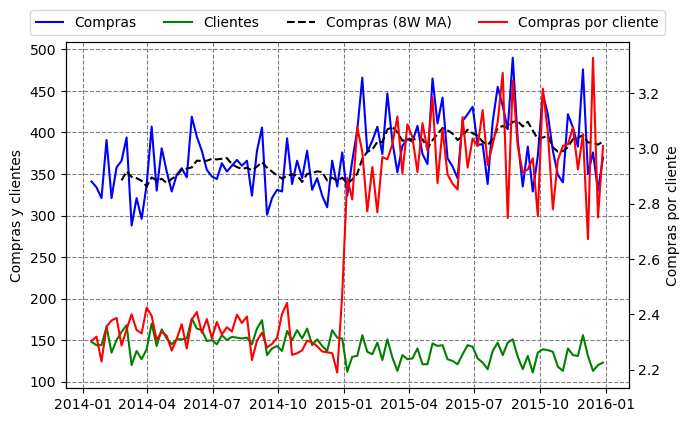

In [10]:
# matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7,4))
ax.grid(linestyle='--', color='gray')
ax.set_ylabel('Compras y clientes')
l1, l2, l3 = ax.plot(g.index, g['quantity'], 'blue',
                 g.index, g['member_number'], 'green',
                 g.index, g['compras_media_movil_8w'], 'k--')

ax2 = ax.twinx()
ax2.set_ylabel('Compras por cliente')
l4, = ax2.plot(g.index, g['compras_por_cliente'], color='red')
fig.tight_layout()
ax.legend((l1, l2, l3, l4),
           ('Compras', 'Clientes', 'Compras (8W MA)', 'Compras por cliente'),
           bbox_to_anchor=(.5,1), loc='lower center', ncol=4)


In [11]:
# bokeh

# parametros de figura
plot_width, plot_height = 700, 300
fig_title = 'Evolucion temporal - ventas y clientes'
tools = 'save', 'box_zoom', 'reset'

# Datos - pasamos a bokeh.models.ColumnDataSource
source = ColumnDataSource(g.reset_index())
print(source.data.keys())

x = 'date'
ys = ('member_number', 'quantity', 'compras_por_cliente')
x_name = 'Fecha'
ys_name = ('Clientes', 'Compras', 'Compras por cliente')
ys_axis = ('default', 'default', 'y2')
ys_colors = bokeh.palettes.Category10_3

# Creamos figura
p = figure(plot_width=plot_width, plot_height=plot_height, title=fig_title, x_axis_type='datetime',
           x_axis_label=x_name)

# Añadimos eje secundario
make_extra_yaxis(p, 'y2', (0, 5), 'Compras por cliente')

for y, yname, ycolor, yaxis in zip(ys, ys_name, ys_colors, ys_axis):
  p.line(x=x, y=y, legend_label=yname, color=ycolor,source=source, y_range_name=yaxis)

# agregamos un hovertool
yformats = ('0', '0', '0.0')
hover = make_hovertool((x, x_name, '%F', 'datetime'), *zip(ys, ys_name, yformats))
p.add_tools(hover)

# ajustamos leyenda
p.add_layout(p.legend[0], 'right')
p.legend.click_policy= 'hide'
show(p)
#bokeh.io.save(p, 'graf1.html')
output_notebook()

dict_keys(['index', 'date', 'quantity', 'member_number', 'compras_por_cliente', 'compras_media_movil_8w'])


Loading BokehJS ...

## Ventas y clientes segun dia de la semana

### Acondicionar datos

In [12]:
g = df.assign(weekday=df['date'].dt.dayofweek     # agregamos el dia de la semana
    ).groupby(['date', 'weekday'], as_index=False # agrupamos por dia de semana y dia
              ).agg({'quantity': 'sum',           # sumamos ventas totales y clientes totales (sin repetir) 
                     'member_number': 'nunique'}
    ).groupby('weekday', as_index=False).mean()   # luego agrupamos por dia de semana y calculamos la media
g['weekday_str'] = ['lunes', 'martes', 'miercoles', 'jueves', 'viernes', 'sabado', 'domingo']

print(g)

   weekday   quantity  member_number weekday_str
0        0  51.750000      19.875000       lunes
1        1  53.442308      20.596154      martes
2        2  53.480769      20.490385   miercoles
3        3  54.038462      21.038462      jueves
4        4  53.480769      20.538462     viernes
5        5  53.375000      20.778846      sabado
6        6  53.173077      20.557692     domingo


### Graficos

In [ ]:
# como antes, ponemos datos, parametros de figura y "ys" a graficar
source = bm.ColumnDataSource(g)
plot_width, plot_height, title = 700, 300, 'histograma por dia de semana'
ys = ('quantity', 'member_number')
ylabels = ('ventas promedio', 'clientes promedio')
colors = ('firebrick', 'navy')

# la diferencia es que ahora usamos un eje x explicito (no numerico)
x_range = g['weekday_str']
p = figure(x_range=x_range, plot_width=plot_width, plot_height=plot_height, title=title)

# ahora tenemos que usar una funcion medio rara para acomodar los histogramas
for c, label, color, offset in zip(ys, ylabels, colors, (-.2, .2)):
    p.vbar(x=bokeh.transform.dodge('weekday_str', offset, range=p.x_range),
           top=c, width=.4, color=color, legend_label=label, source=source)

# añadimos leyenda y graficamos
p.add_layout(p.legend[0], 'right')
show(p)
output_notebook()

## Distribucion tamaño de las canastas

### Acondicionar datos

In [ ]:
g = df.groupby('transaction_id')[['quantity']].sum()

hist, edges = np.histogram(g.values, density=True)
hist /= hist.sum()
hist
hist_x = (edges[:-1] + edges[1:]) / 2
hist_cum = hist.cumsum()

print(sep)
print(hist)


----------

[6.73661699e-01 1.80311435e-01 9.28958097e-02 2.29900421e-02
 1.16955156e-02 5.34652142e-03 9.69057007e-03 3.34157589e-03
 0.00000000e+00 6.68315177e-05]


### Graficos

In [ ]:
plot_height, plot_width = 300, 500
x_axis_label =  'productos por compra'
y_axis_label = 'Frecuencia'
tools = ['box_zoom', 'save', 'reset']

p = figure(x_axis_label=x_axis_label, y_axis_label=y_axis_label,
           plot_width=plot_width, plot_height=plot_height, tools=tools, y_range=(0, 1))
hover = make_hovertool(x=(x_axis_label, '0.0'), y=('y', '0%'))
p.add_tools(hover)

p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
            fill_color="navy", line_color="white", alpha=0.5, legend_label='PDF')
p.line(hist_x, hist_cum, color='firebrick', legend_label='CDF')

show(p)
output_notebook()

## Pareto ventas por item

In [ ]:
g = df.groupby('item_description')[['quantity']].sum()
g['quantity'] = g['quantity'] / df.date.nunique()
g['quantity_p'] = g['quantity'] / g['quantity'].sum()
g['item_count'] = 1

bins = np.linspace(0,1,11)
bins_x = (bins[1:] + bins[:-1]) / 2
g['cuantil_q'] = pd.qcut(g['quantity'], bins)
print(g.sample(3), sep)

g = g.groupby('cuantil_q')[['item_count', 'quantity_p', 'quantity']].sum()
g = g.sort_values(by='quantity_p', ascending=False)
print(g.sum())
g['item_count_c'] = g['item_count'].cumsum()
g['quantity_pc'] = g['quantity_p'].cumsum()
g

                          quantity  quantity_p  item_count        cuantil_q
item_description                                                           
margarine                 0.674451    0.012666           1   (0.458, 0.805]
long life bakery product  0.369505    0.006939           1    (0.31, 0.458]
female sanitary products  0.054945    0.001032           1  (0.0519, 0.083] 
----------

item_count    167.000000
quantity_p      1.000000
quantity       53.248626
dtype: float64


,item_count,quantity_p,quantity,item_count_c,quantity_pc
cuantil_q,,,,,
"(0.805, 3.437]",17,0.481310,25.629121,17,0.481310
"(0.458, 0.805]",17,0.205005,10.916209,34,0.686315
"(0.31, 0.458]",16,0.112473,5.989011,50,0.798788
"(0.185, 0.31]",17,0.079737,4.245879,67,0.878524
"(0.117, 0.185]",16,0.044989,2.395604,83,0.923513
"(0.083, 0.117]",17,0.031936,1.700549,100,0.955450
"(0.0519, 0.083]",17,0.020844,1.109890,117,0.976293
"(0.0305, 0.0519]",16,0.012640,0.673077,133,0.988933
"(0.0173, 0.0305]",17,0.008126,0.432692,150,0.997059


In [ ]:
plot_height, plot_width = 300, 500
x_axis_label =  'Items [%]'
y_axis_label = 'Ventas [%]'
tools = ['box_zoom', 'save', 'reset']

p = figure(x_axis_label=x_axis_label, y_axis_label=y_axis_label,
           plot_width=plot_width, plot_height=plot_height, tools=tools, y_range=(0, 1))
hover = make_hovertool(x=(x_axis_label, '0%'), y=(y_axis_label, '0%'))
p.add_tools(hover)

top = g['quantity_p']
p.quad(top=top, bottom=0, left=bins[:-1], right=bins[1:],
            fill_color="navy", line_color="white", alpha=0.5, legend_label='PDF')
p.line(bins_x, top.cumsum(), color='firebrick', legend_label='CDF')

show(p)
output_notebook()

## Pareto ventas por cliente

In [ ]:
g = df.groupby('member_number')[['quantity']].sum()
g['quantity'] = g['quantity'] / df.date.nunique()
g['quantity_p'] = g['quantity'] / g['quantity'].sum()
g['member_count'] = 1
g = g.sort_values(by='quantity', ascending=False)

bins = np.linspace(0,1,11)
bins_x = (bins[1:] + bins[:-1]) / 2
g['cuantil_q'] = pd.qcut(g['quantity'], bins)
print(g.sample(3), sep)

g = g.groupby('cuantil_q')[['member_count', 'quantity_p', 'quantity']].sum()
g = g.sort_values(by='quantity_p', ascending=False)
print(g.sum())
g['member_count_c'] = g['member_count'].cumsum()
g['quantity_pc'] = g['quantity_p'].cumsum()
g

               quantity  quantity_p  member_count           cuantil_q
member_number                                                        
3452           0.010989    0.000206             1    (0.00824, 0.011]
2172           0.006868    0.000129             1  (0.00549, 0.00687]
3083           0.013736    0.000258             1    (0.0124, 0.0151] 
----------

member_count    3898.000000
quantity_p         1.000000
quantity          53.248626
dtype: float64


,member_count,quantity_p,quantity,member_count_c,quantity_pc
cuantil_q,,,,,
"(0.0234, 0.0495]",340,0.185528,9.879121,340,0.185528
"(0.0192, 0.0234]",389,0.159654,8.501374,729,0.345183
"(0.0124, 0.0151]",538,0.145131,7.728022,1267,0.490313
"(0.0165, 0.0192]",371,0.129034,6.870879,1638,0.619347
"(0.00824, 0.011]",578,0.113169,6.026099,2216,0.732516
"(0.0151, 0.0165]",252,0.078009,4.153846,2468,0.810525
"(0.011, 0.0124]",251,0.058274,3.103022,2719,0.868799
"(0.00687, 0.00824]",371,0.057423,3.057692,3090,0.926222
"(0.0017499999999999998, 0.00549]",630,0.050819,2.706044,3720,0.977041


In [ ]:
plot_height, plot_width = 300, 500
x_axis_label =  'Clientes [%]'
y_axis_label = 'Ventas [%]'
tools = ['box_zoom', 'save', 'reset']

p = figure(x_axis_label=x_axis_label, y_axis_label=y_axis_label,
           plot_width=plot_width, plot_height=plot_height, tools=tools, y_range=(0, 1))
hover = make_hovertool(x=(x_axis_label, '0%'), y=(y_axis_label, '0%'))
p.add_tools(hover)

top = g['quantity_p']
p.quad(top=top, bottom=0, left=bins[:-1], right=bins[1:],
            fill_color="navy", line_color="white", alpha=0.5, legend_label='PDF')
p.line(bins_x, top.cumsum(), color='firebrick', legend_label='CDF')

show(p)
output_notebook()

# A priori

## Teoria

**A priori / Asociacion**

(ver https://en.wikipedia.org/wiki/Association_rule_learning o googlear "market basket analysis")

Sea $A$ una entidad (e.g. tomates, jugo, cerveza), y sea $P(A)$ la proporcion de ordenes de compra donde aparece $A$

Sea $B$ otra entidad. Definimos la probabilidad condicional:

$\frac{P(A \cap B)}{P(A)} = P(B/A) = P(A \rightarrow B) $

**Ejemplo de como leer:** $P(A \rightarrow B) = 14\%$ se lee "el 14% de las veces que compro A, la orden tambien contiene B". Obs: En este ejemplo, "A" se llama antecedente y "B" se llama consecuente

Definimos:
* $P(A)$, $P(B)$: soporte de A y B
* $P(B/A) = P(A \rightarrow B) $: confianza de $A \rightarrow B$
* $\frac{P(B/A)}{P(B)} = \frac{P(A \rightarrow B)}{P(B)} $, "Lift"

Dos items muy frecuentes (e.g. cerveza y leche) probablemente se compren juntos aun sin estar asociados. Observar que $P(B)= 1 \Rightarrow P(B/A)=1$. Para eso se puede usar el lift

## Imports - Herramientas para modelizar

In [15]:
from mlxtend import frequent_patterns as fp
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
# si da ModuleNotFoundError, instalar el paquete haciendo:
# !pip install mlxtend (en google colab)
# pip install mlxtend (en anaconda o python local)

## Acondicionar datos

In [16]:
g = df.groupby('transaction_id')['item_description'].agg(tuple)
print('total de transacciones:', len(g))
print('Total de items diferentes:', df['item_description'].nunique())
print('combinaciones observadas:', g.nunique())
print('Combinaciones posibles: {:.2E}'.format(2**df['item_description'].nunique()))

te = TransactionEncoder()
tx = te.fit_transform(g)
df_te = pd.DataFrame(tx, columns=te.columns_)
del tx # para ahorrar memoria
df_te.sample(3)

total de transacciones: 14963
Total de items diferentes: 167
combinaciones observadas: 9111
Combinaciones posibles: 1.87E+50


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
6363,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13198,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13364,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Aplicar modelo

In [17]:
min_support = .005
canastas = apriori(df_te, min_support, use_colnames=True, max_len=2)
print('Total datos:', len(canastas))
canastas = canastas.sort_values(by='support', ascending=False)
canastas.head(10)

Total datos: 126


,support,itemsets
87,0.157923,(whole milk)
53,0.122101,(other vegetables)
66,0.110005,(rolls/buns)
75,0.097106,(soda)
88,0.085879,(yogurt)
67,0.069572,(root vegetables)
81,0.067767,(tropical fruit)
6,0.060683,(bottled water)
70,0.060349,(sausage)
19,0.053131,(citrus fruit)


In [18]:
reglas = fp.association_rules(canastas, metric='confidence', min_threshold=.05)

reglas = reglas.sort_values(by='lift', ascending=False)
reglas['antecedent'] = reglas['antecedents'].apply(iter).apply(next)
reglas['consequent'] = reglas['consequents'].apply(iter).apply(next)

print('relaciones totales:', len(reglas), sep)
print('Antecedentes: ({})'.format(reglas['antecedent'].nunique()), reglas['antecedent'].unique(), sep)
print('Consecuentes: ({})'.format(reglas['consequent'].nunique()), reglas['consequent'].unique(), sep)
reglas.head(10)

relaciones totales: 57 
--------------------

Antecedentes: (19) ['frankfurter' 'yogurt' 'sausage' 'soda' 'bottled beer' 'whole milk'
 'newspapers' 'domestic eggs' 'tropical fruit' 'pork' 'pip fruit'
 'citrus fruit' 'shopping bags' 'rolls/buns' 'other vegetables'
 'canned beer' 'pastry' 'root vegetables' 'bottled water'] 
--------------------

Consecuentes: (8) ['other vegetables' 'sausage' 'yogurt' 'soda' 'whole milk'
 'tropical fruit' 'rolls/buns' 'root vegetables'] 
--------------------



,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent,consequent
55,(frankfurter),(other vegetables),0.037760,0.122101,0.005146,0.136283,1.116150,0.000536,1.016420,0.108146,frankfurter,other vegetables
40,(yogurt),(sausage),0.085879,0.060349,0.005748,0.066926,1.108986,0.000565,1.007049,0.107508,yogurt,sausage
39,(sausage),(yogurt),0.060349,0.085879,0.005748,0.095238,1.108986,0.000565,1.010345,0.104587,sausage,yogurt
36,(sausage),(soda),0.060349,0.097106,0.005948,0.098560,1.014975,0.000088,1.001613,0.015702,sausage,soda
35,(soda),(sausage),0.097106,0.060349,0.005948,0.061253,1.014975,0.000088,1.000963,0.016341,soda,sausage
25,(bottled beer),(whole milk),0.045312,0.157923,0.007151,0.157817,0.999330,-0.000005,0.999874,-0.000702,bottled beer,whole milk
13,(sausage),(whole milk),0.060349,0.157923,0.008955,0.148394,0.939663,-0.000575,0.988811,-0.063965,sausage,whole milk
12,(whole milk),(sausage),0.157923,0.060349,0.008955,0.056708,0.939663,-0.000575,0.996140,-0.070851,whole milk,sausage
43,(newspapers),(whole milk),0.038896,0.157923,0.005614,0.144330,0.913926,-0.000529,0.984114,-0.089246,newspapers,whole milk
52,(domestic eggs),(whole milk),0.037091,0.157923,0.005280,0.142342,0.901341,-0.000578,0.981834,-0.102072,domestic eggs,whole milk


## Graficar

In [19]:
# usamos un modulo especial que nos permite modelizar relaciones entre entidades
import networkx as nx

In [20]:
# primero creamos un objeto networkx antecedente -> consequente
threshold = .9
G = nx.DiGraph()
atributos = ('support', 'confidence', 'antecedent support', 'consequent support', 'lift')

for i, r in reglas[reglas['lift']>=threshold].iterrows():
  G.add_edge(r['antecedent'], r['consequent'], index=i, **{a: r[a] for a in atributos})
print('Nodos:', G.number_of_nodes(), '-', 'Relaciones:', G.number_of_edges())
G.nodes()

Nodos: 9 - Relaciones: 10


NodeView(('frankfurter', 'other vegetables', 'yogurt', 'sausage', 'soda', 'bottled beer', 'whole milk', 'newspapers', 'domestic eggs'))

C:\Users\MStainoh\AppData\Local\Temp\ipykernel_9180\3402323219.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='confidence')


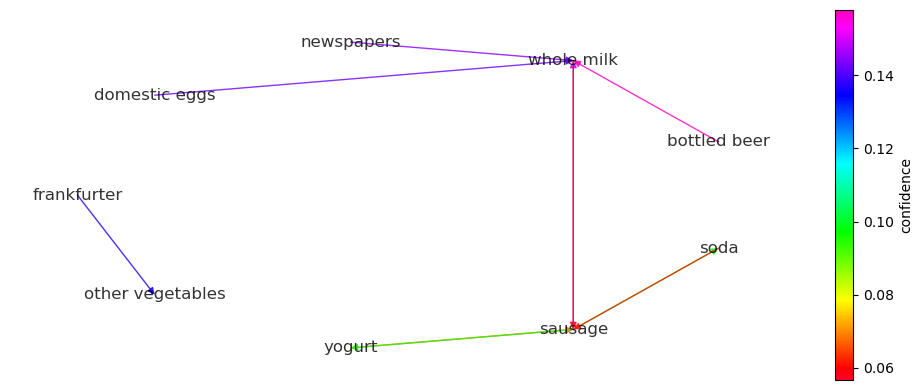

In [21]:
fig, ax = plt.subplots(figsize=(10,4))
pos = nx.shell_layout(G)

edges, weights = zip(*nx.get_edge_attributes(G,'confidence').items())

nx.draw(G, pos, ax=ax, node_size=0, alpha=0.8,
        edge_color=weights, width=1.0, edge_cmap=plt.cm.gist_rainbow,
        font_size=12, with_labels=True)
fig.tight_layout()

cmap = mpl.cm.gist_rainbow
norm = mpl.colors.Normalize(vmin=min(weights), vmax=max(weights))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
plt.colorbar(sm, label='confidence')
plt.show()